In [77]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report

In [78]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
pre_trained_model = tf.keras.applications.InceptionV3(input_shape = (224, 224, 3),
    include_top=False, weights='imagenet'
)

In [39]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

In [79]:
for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 12, 12, 768)


In [80]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(2, activation='sigmoid')(x)           

model = Model(inputs=pre_trained_model.input, outputs=x) 

for layer in pre_trained_model.layers:
	layer.trainable = False

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

/Users/thana/Workspace/Class/image_project/project/env/lib/python3.9/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [81]:
import glob
from keras.preprocessing import image
import numpy as np
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer

filenames = glob.glob("dataset/*/*.jpg")
print(len(filenames))

# Load image files and Resize (h,w,ch) -> h = w < 100 , ch = 3 (R,G,B)
data = []
labels = []

for idx, img_path in enumerate(filenames):
    label = img_path.split(os.path.sep)[-2]

    img = image.load_img(img_path, target_size=(224, 224), interpolation="nearest")
    img = image.img_to_array(img)
    img = preprocess_input(img) ## using inception_v3

    # update the data and labels lists, respectively
    labels.append(label)
    data.append(img)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

3762


In [82]:
from sklearn.model_selection import train_test_split
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [67]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(3009, 224, 224, 3)
(3009, 2)
(753, 224, 224, 3)
(753, 2)


In [83]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")


In [86]:
H = model.fit(
                    aug.flow(trainX, trainY, batch_size=BS),
                    validation_data=(testX, testY),
                    steps_per_epoch=12,
                    epochs=5,
                    validation_steps=9,
                    verbose=1)


Epoch 1/5
12/12 [==============================] - 38s 3s/step - loss: 0.1087 - accuracy: 0.9635 - val_loss: 0.0257 - val_accuracy: 0.9907
Epoch 2/5
12/12 [==============================] - 35s 3s/step - loss: 0.0578 - accuracy: 0.9870 - val_loss: 0.0403 - val_accuracy: 0.9788
Epoch 3/5
12/12 [==============================] - 34s 3s/step - loss: 0.0709 - accuracy: 0.9870 - val_loss: 0.0139 - val_accuracy: 0.9973
Epoch 4/5
12/12 [==============================] - 32s 3s/step - loss: 0.0812 - accuracy: 0.9773 - val_loss: 0.0148 - val_accuracy: 0.9934
Epoch 5/5
12/12 [==============================] - 36s 3s/step - loss: 0.0088 - accuracy: 0.9974 - val_loss: 0.0059 - val_accuracy: 0.9960


[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       0.99      1.00      1.00       367
without_mask       1.00      0.99      1.00       386

    accuracy                           1.00       753
   macro avg       1.00      1.00      1.00       753
weighted avg       1.00      1.00      1.00       753

[INFO] saving mask detector model...


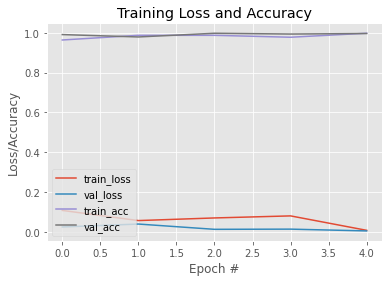

In [89]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("model", save_format="h5")

# plot the training loss and accuracy
N = 5
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("test2")